In [8]:
# IMPORTS
from langwahge import * 
from mynn.optimizers.sgd import SGD
import numpy as np
import mygrad as mg
%matplotlib notebook

In [2]:
# LOAD IN DATA
data = Coco()
coco_data, glove, resnet18_features, imgid_to_capid, capid_to_imgid, capid_to_capstr, vocab_counts, idfs_dict = data.get_data()

<IPython.core.display.Javascript object>


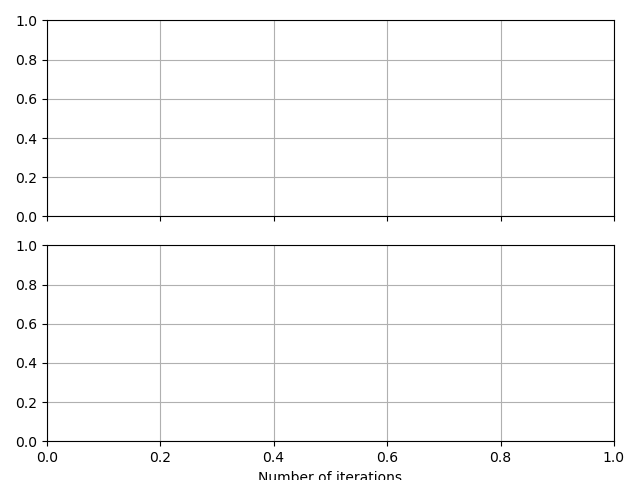

In [13]:
# NOGGIN SETUP
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"],max_fraction_spent_plotting=.75)

In [14]:
# TRIPLETS
triplets = []
for _ in range(80000):
    # generate two random pairs to compose this triplet
    ran_img_id, ran_cap_id = data.random_pair()
    confusor_img_id, confusor_cap_id = data.random_pair()
    
    # in case random and confusor images end up the same
    while ran_img_id == confusor_img_id:
        confusor_img_id, confusor_cap_id = data.random_pair()
        
    # append new triplet
    triplets.append((ran_cap_id, ran_img_id, confusor_img_id))

In [15]:
# SPLITTING

# 4/5 and 1/5
split_at = 0.8 
split = int(len(triplets) * split_at)

# 4/5 training
train_triplets = np.array(triplets[:split]) 

# 1/5 validation
valid_triplets = np.array(triplets[split:])

In [16]:
# TRAINING

# initialize model and optimizer
model = Model(512, 200)
optim = SGD(model.parameters, learning_rate = 1e-3, momentum =0.9)

# among training triplets, compile list of caption IDs
captionidlist = [i[0] for i in train_triplets]
# also get their respective string counterparts
list_phrases = [capid_to_capstr[i] for i in captionidlist]
# and use those strings to get caption embeddings
caption_embeddings = np.array([data.embed_text(i) for i in list_phrases])

# among validation triplets, compile list of caption IDs
v_captionidlist = [i[0] for i in valid_triplets]
# also get their respective string counterparts
v_list_phrases = [capid_to_capstr[i] for i in v_captionidlist]
# an use those strings to get caption embeddings
v_caption_embeddings = np.array([data.embed_text(i) for i in v_list_phrases])

# batches and epochs
batch_size = 32
num_epochs = 30

# main training loop
for epoch in range(num_epochs):
    
    # batch control
    indexes = np.arange((len(train_triplets)))
    np.random.shuffle(indexes)
    for batch_count in range(0, len(train_triplets) // batch_size):
        batch_indexes = indexes[batch_count*batch_size : (batch_count + 1) * batch_size]
        img_ids = [i[1] for i in train_triplets[batch_indexes]]
        
        # get normal "predictions" for this batch
        img_batch = []
        for img_id in img_ids: 
            if img_id in data.resnet18_features.keys(): # in case of rare coco img id w/ no resnet dvector
                img_batch.append(data.vectorize_image(img_id))
        img_preds = model(mg.tensor(img_batch))
        
        # get confuser "predictions" for this batch
        conf_ids = [j[2] for j in train_triplets[batch_indexes]]
        conf_batch = []
        for conf_id in conf_ids:
            if conf_id in data.resnet18_features.keys(): # in case of rare coco img id w/ no resnet dvector
                conf_batch.append(data.vectorize_image(conf_id))
        conf_preds = model(mg.tensor(conf_batch))
        
        # get caption_embeddings for this batch
        caption_embeddings = caption_embeddings[batch_indexes]
        
        sim_match = (caption_embeddings*img_preds).sum(axis = -1)
        sim_confuse = (caption_embeddings*conf_preds).sum(axis = -1)
        
        # compute loss and accuracy (double-check model.py)
        loss, acc = loss_accuracy(sim_match, sim_confuse, 0.25, triplet_count=len(train_triplets))
        loss.backward()
        
        optim.step()
        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc}, batch_size=batch_size)

# save weights from the trained model
filename = save_weights(model)

IndexError: index 10543 is out of bounds for axis 0 with size 32